# StackGP.evolve
```{python}
StackGP.evolve(inputData, responseData, generations=100, ops=defaultOps(), const=defaultConst(), variableNames=[], mutationRate=79, crossoverRate=11, spawnRate=10, extinction=False,extinctionRate=10,elitismRate=50,popSize=300,maxComplexity=100,align=True,initialPop=[],timeLimit=300,capTime=False,tourneySize=5,tracking=False,liveTracking=False, liveTrackingInterval=1, modelEvaluationMetrics=[fitness,stackGPModelComplexity],dataSubsample=False, samplingMethod=randomSubsample, sharpnessAware=False)
```

Evolve is the core search engine within StackGP and is responsible for running the evolutionary search. 

In the minimal use case, you need to supply and input dataset and a response vector to fit. 

There are many optional arguments: 

* **generations**: The number of generations to run the search for. Default=100.
* **ops**: The math operators to allow in the search space. To use the default set ops=defaultOps().
* **const**: The constants to be used in the search space. The default allows $\pi$, $e$, random integers from -3 to 3, and random reals from -10 to 10. To use the default set const=defaultConst().
* **variableNames**: Takes a list of names to be assigned to the input variables. The list size should be the same as the number of input terms. If no list is supplied, variables will be labelled $x_1$, $x_2$, ...
* **mutationRate**: Controls the percentage of models which will undergo mutation in each generation. The default is 79%.
* **crossoverRate**: Controls the percentage of models that will be produced via crossover in each generation. The default is 11%.
* **spawnRate**: Controls the number of random individuals to be injected in each generation. The default is 10% of the populuation size.
* **extinction**: Determines if models not on the Pareto front will be wiped out every _extinctionRate_ generations. The default is set to false. 
* **extinctionRate**: Controls the rate that models not on the Pareto front will be wiped out if _extinction_ is set to true. The default is every 10 generations if extinctions are enabled.
* **elitismRate**: Controls the percentage of elite models that will be preserved across generations. The default is set to 50%. 
* **popSize**: Controls the population size during search. The default is 300. 
* **maxComplexity**: Sets the maximum complexity of models allowed during search. Any models that exceed this will be removed from the population. The default is set to 100. 
* **align**: Binary setting to control if the models will undergo linear scaling at the end of search. The default is set to true. 
* **initialPop**: Takes a list of models to seed the search space. By default, it is set to an empty list. 
* **timeLimit**: Controls the maximum time allowed for search in seconds. If _generations_ is not reached by the _timeLimit_ the search will terminate with the current population. _capTime_ must be set to true to enable this. By default the value for _timeLimit_ is set to 300 second but it is not active. 
* **capTime**: Binary setting to determine if search should be time constrained by the set _timeLimit_. By default this is set to false. 
* **tourneySize**: The size of tournaments used during search. The default is 5. 
* **tracking**: Binary setting to determine if a plot of the search trace should be displayed after the search completes. By default this is set to false. 
* **liveTracking**: Binary setting to determine if a plot of the search trace should be displayed live during the search. By default this is set to false. This is supported currently just in Jupyter Notebooks. 
* **liveTrackingInterval**: The interval in seconds between refreshes of the liveTracking plot. Setting this value to 0 will update the figure every generation. 
* **modelEvaluationMetrics**: Controls which objectives are used during search. It can take a list of arbitrary length. Pareto tournaments will determine winners from each tournament across all objectives. The default is set to [fitness, stackGPModelComplexity]. 
* **dataSubsample**: Binary setting to determine if the training data should be subsampled in each generation. 
* **samplingMethod**: Controls which sampling method is used if `dataSubsample=True`. Options are `randomSubsample` and `generationProportionalSample` or any user defined function of the form `func(input,response)` and returns a subsampled input and response. 
* **sharpnessAware**: (Coming soon!) Binary setting to determine if sharpness-aware minimization will be used during search to promote smoother model development. By default this is set to false. 

---

First we need to load in the necessary packages

In [1]:
import StackGP as sgp
import numpy as np

## Overview

### Define Function

Here we define the function which we will try to rediscover. 

In [3]:
#Define demo function to generate data
def demoFunc(x,y):
    return x**2/y

### Data Generation

Now we can generate some data that we will use in the search. 

In [5]:
#Generate data
inputData=np.array([np.random.randint(1,10,10),np.random.randint(1,10,10)])
response=demoFunc(inputData[0],inputData[1])

### GP Search

Here we supply the input data and response to StackGP's evolve function to search for a model that fits the data. 

In [6]:
#Generate models
models=sgp.evolve(inputData,response)

### Results

Now we can visualize the Pareto front plot of the evolved models to see how they perform with respect to accuracy and complexity. 

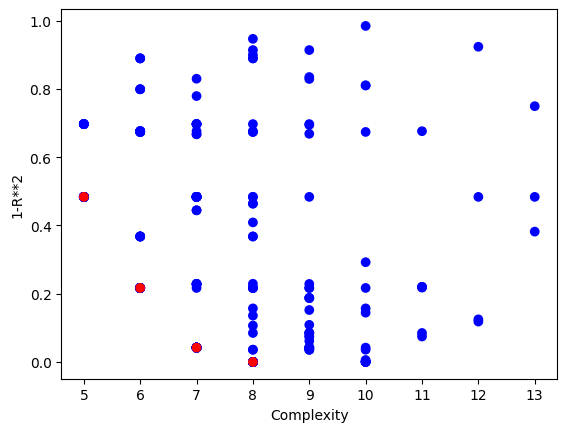

In [7]:
#View model population quality
sgp.plotModels(models)

We can use the printGPModel function to print the best model in a readable format. We can see that the correct model form was found. 

In [8]:
#View best model
sgp.printGPModel(models[0])

1.0*x0**2/x1 + 1.84213875231584e-15

We can also plot a comparison between predicted and observed values. Since the model fits the data perfectly, we only see the predicted points in the plot since they cover the observed points. 

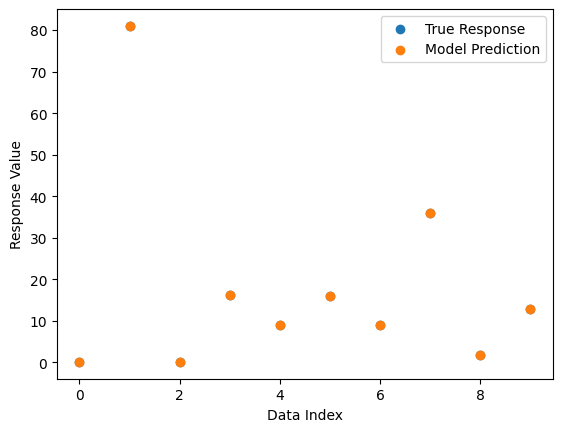

In [10]:
#Compare best model prediction to true data
sgp.plotModelResponseComparison(models[0],inputData,response)

---
---

## Options

This section showcases how each of the different option settings can be used with the evolve function. 

---

### generations

_generations_ can be used to control how many generations are used in search. The default is to use 100, but if the problem is difficult it may be beneficial to increase this. 

First lets setup a somewhat challenging problem with nonlinear patterns. As well, we won't include cosine, sine, or log in the search space, so we will have to find an approximate model. 

In [4]:
#Define a challenging function to generate data
def demoFunc(x,y):
    return np.sin(x) * np.cos(y) + np.log(x + y)
#Generate data
inputData=np.array([np.random.randint(1,10,10),np.random.randint(1,10,10)])
response=demoFunc(inputData[0],inputData[1])

Now lets try fitting with the default settings. We will turn on tracking so we can see the progress. 

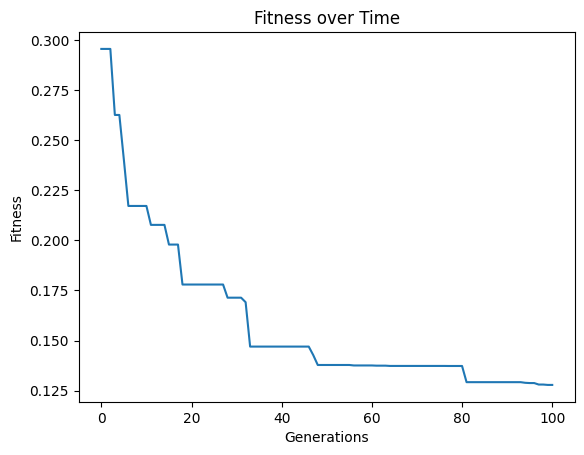

In [5]:
#Generate models
models=sgp.evolve(inputData,response,tracking=True)

Now lets crank up the number of generations to see if we can get closer. 

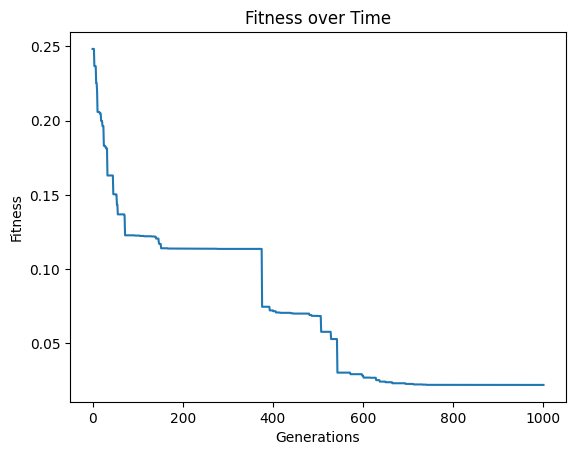

In [6]:
#Generate models
models=sgp.evolve(inputData,response,generations=1000,tracking=True)

We can see that the extra generations allowed us to get a much better fitness score. 

---

### ops

By default _ops_ is set to defaultOps(), which contains: div, add, sub, mult, exp, sqrd, sqrt, and inv. These are generally good to try as a starting point since including too many terms or including highly nonlinear terms when they aren't needed can lead to overfitting. 

First lets demonstrate the default case on a problem where the operator set is not sufficient to find a perfect solution. 

In [26]:
#Define a challenging function to generate data
def demoFunc(x,y):
    return np.sin(x) * y
#Generate data
inputData=np.array([np.random.randint(1,10,10),np.random.randint(1,10,10)])
response=demoFunc(inputData[0],inputData[1])

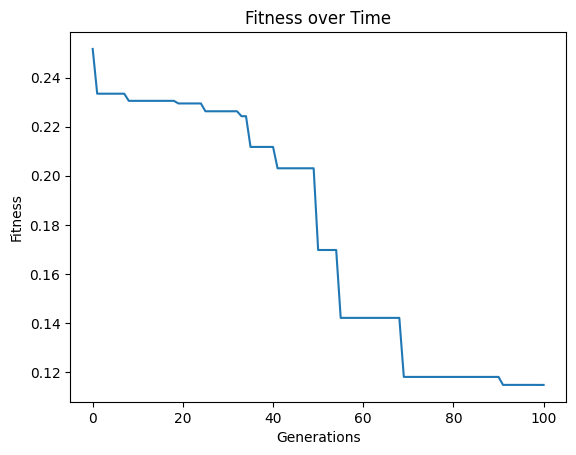

In [32]:
#Generate models
models=sgp.evolve(inputData,response,tracking=True)

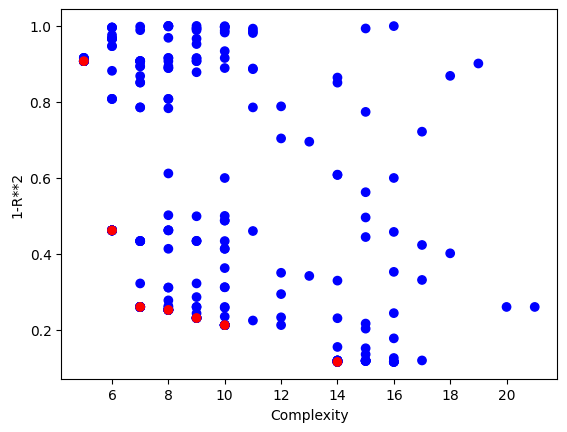

In [33]:
#Plot models
sgp.plotModels(models)

In [34]:
#View best model
sgp.printGPModel(models[0])

-1.28467623935421 + 3.73315459033536*(-0.510402102903892*x0 + 0.255201051451946*x1 + 1)**2/x0

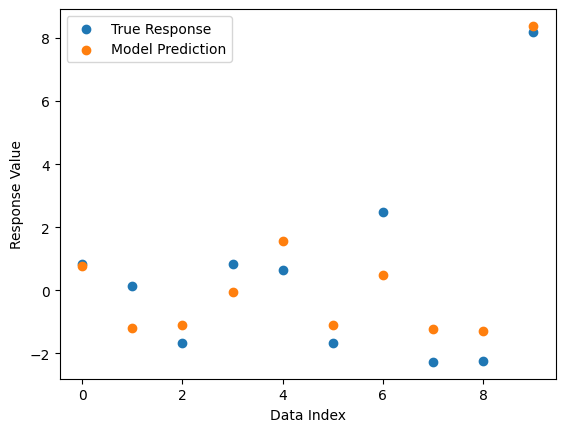

In [35]:
#Compare best model prediction to true data
sgp.plotModelResponseComparison(models[0],inputData,response)

Now we set _ops_ to allOps() which includes default set plus trig functions and log. This makes it possible to find an exactl solution. 

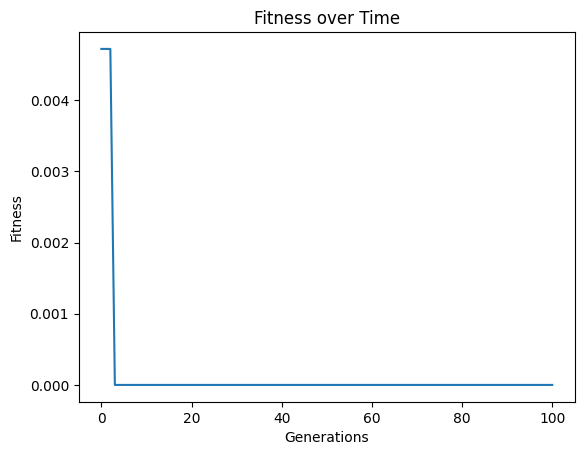

In [36]:
#Generate models
models=sgp.evolve(inputData,response,ops=sgp.allOps(), tracking=True)

In [37]:
#View best model
sgp.printGPModel(models[0])

1.0*x1*sin(x0) + 3.92730806292441e-16

We can see now that the solution was discovered. 

---

### const

The _const_ option allows for control over what constants are to be used when generating random models. The default settings of `defaultConst()` captures many commonly used constants, but there may be instances where these are not sufficient or domain knowledge can be used to provide a better set. 

In [98]:
#Define a challenging function to generate data
def demoFunc(x,y):
    return np.pi*x / (np.pi/2 + y)
#Generate data
inputData=np.array([np.random.randint(1,10,10),np.random.randint(1,10,10)])
response=demoFunc(inputData[0],inputData[1])

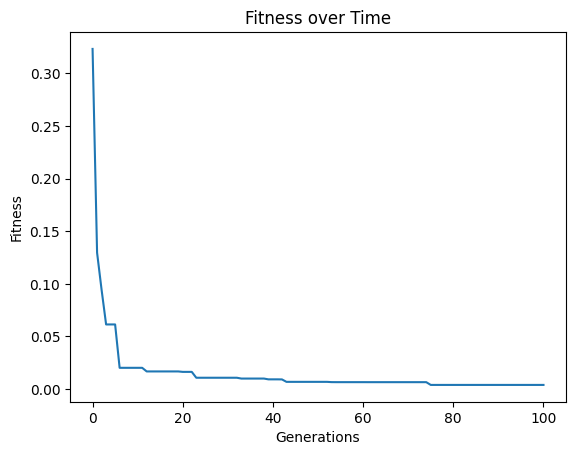

In [99]:
#Generate models
models=sgp.evolve(inputData,response,tracking=True,ops=sgp.allOps(),const=sgp.defaultConst())

In [100]:
#View best model
sgp.printGPModel(models[0])

-2.26179265560533*x0/(-0.83630867262685*x1 - 0.993221474868728) + 0.186790630712822

In the above case, we can see that while we did get a good fitness, the search struggled to find the correct constants and resorted to do its best to approximate the data. 

Below, we demonstrate that if we supply the search with good constants, we can make the search much easier. This example outlines and extreme scenario where we happen to know the correct constants. This is unlikely to occur in practice, but it provides good insight into how the constant set can impact search. 

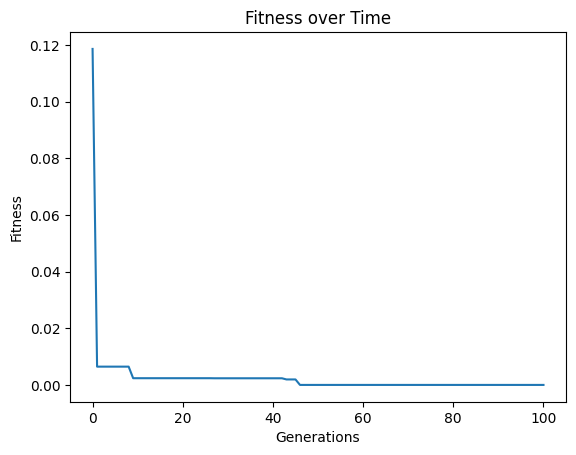

In [101]:
#Generate models
models=sgp.evolve(inputData,response,tracking=True,ops=sgp.allOps(),const=[np.pi, np.pi/2])

In [102]:
#View best model
sgp.printGPModel(models[0])

3.14159265358979*x0/(x1 + 1.5707963267949) + 3.39225006206524e-16

We can see that we discovered the correct model in this case by supplying the correct constants. 

---

### variableNames

By default, variables are named $x1$, $x2$, ... Likely you will know the names of features in your dataset, so we can supply those to the search to build models with the supplied names to improve their interpretability. 

In [ ]:
#Define a function to generate data
def pressureFunc(temperature,volume):
    return temperature/volume
#Generate data
inputData=np.array([np.random.randint(1,10,10),np.random.randint(1,10,10)])
response=pressureFunc(inputData[0],inputData[1])

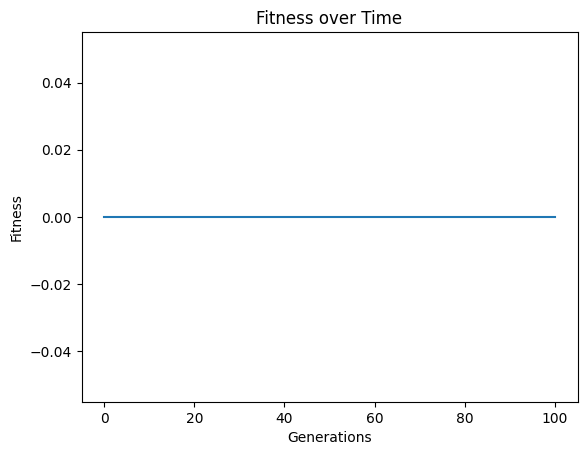

In [91]:
#Generate models
models=sgp.evolve(inputData,response,tracking=True)

In [96]:
#View best model
sgp.printGPModel(models[0],symbols(['temperature','volume']))

1.0*temperature/volume - 4.90163564682915e-16

While the default case does find a model that perfectly fits the data, there is no reason to leave it to the user to interpret the default variable names and convert them to something informative. Rather, we can just supply them directly to the search. (**Note**: This is not fully supported yet to embed the feature names in evolution, but this is a placeholder for when it is supported. For now we can still see the interpretable form by supplying the names to **printGPModel**)

In [ ]:
#Generate models
from sympy import symbols
models=sgp.evolve(inputData,response,tracking=True,ops=sgp.allOps(),variableNames=symbols(['temperature','volume']))

In [95]:
#View best model
sgp.printGPModel(models[0],symbols(['temperature','volume']))

1.0*temperature/volume - 4.90163564682915e-16

### mutationRate

We can control the percentage of model created in each generation from mutation by modifying the _mutationRate_. It may be the case that mutation is either better or worse suited for the problem than crossover or random generation of models, so we can tune this. The default setting should be reasonably robust, so it is not expected that you will have to modify this setting. As well, evolutionary search tends to be pretty robust to a wide range of settings here, so it is unlikely much will change when moving these parameters around. 

In [135]:
#Define a challenging function to generate data
def demoFunc(x,y):
    return np.sin(x) * y
#Generate data
inputData=np.array([np.random.randint(1,10,10),np.random.randint(1,10,10)])
response=demoFunc(inputData[0],inputData[1])

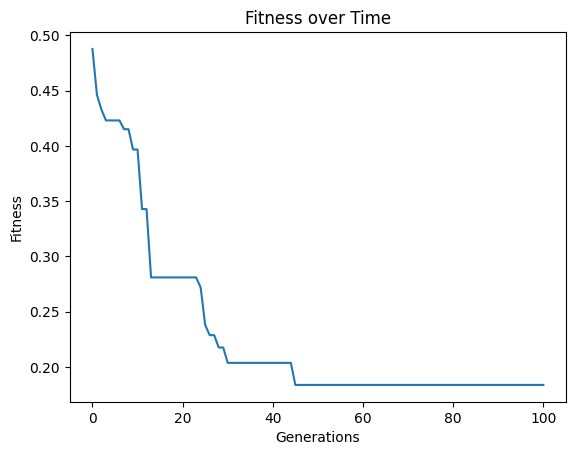

In [136]:
#Generate models
models=sgp.evolve(inputData,response,tracking=True,mutationRate=79, crossoverRate=11, spawnRate=5, elitismRate=5)

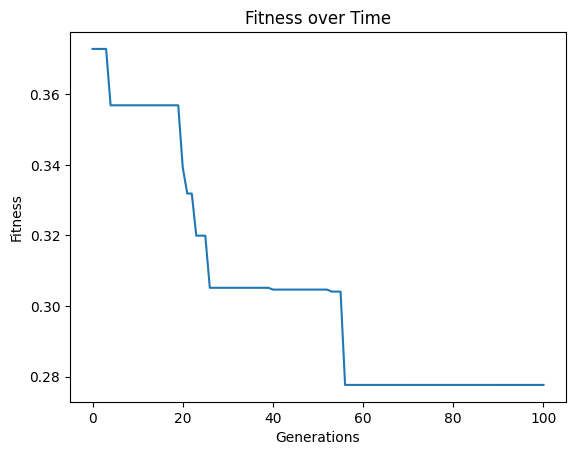

In [137]:
#Generate models
models=sgp.evolve(inputData,response,tracking=True,mutationRate=10,spawnRate=10,crossoverRate=70,elitismRate=10)

### crossoverRate

We can control the percentage of model created in each generation from crossover by modifying the _crossoverRate_. It may be the case that crossover is either better or worse suited for the problem than mutation or random generation of models, so we can tune this. The default setting should be reasonably robust, so it is not expected that you will have to modify this setting. As well, evolutionary search tends to be pretty robust to a wide range of settings here, so it is unlikely much will change when moving these parameters around. 

In [132]:
#Define a challenging function to generate data
def demoFunc(x,y):
    return np.sin(x) * y
#Generate data
inputData=np.array([np.random.randint(1,10,10),np.random.randint(1,10,10)])
response=demoFunc(inputData[0],inputData[1])

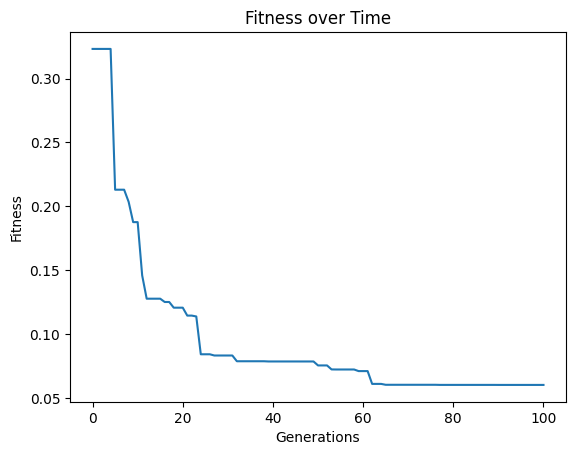

In [133]:
#Generate models
models=sgp.evolve(inputData,response,tracking=True, crossoverRate=11, mutationRate=79, spawnRate=5, elitismRate=5)

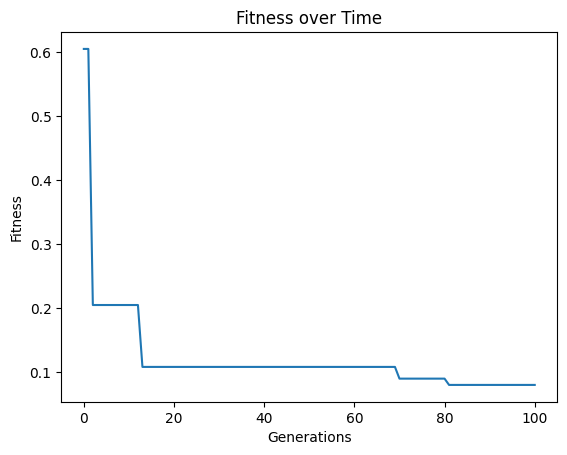

In [134]:
#Generate models
models=sgp.evolve(inputData,response,tracking=True,crossoverRate=70,mutationRate=10,spawnRate=10,elitismRate=10)

### spawnRate

We can control the percentage of random model introduced each generation by modifying the _spawnRate_. Some problems may be especially difficult an prone to leading evolution to lock in early, if this is the case, we may want to introduce novelty into the search space by injecting new random models. Note, if this value is too high, the search becomes equivalent to random search. 

In [127]:
#Define a challenging function to generate data
def demoFunc(x,y):
    return np.sin(x) * y
#Generate data
inputData=np.array([np.random.randint(1,10,10),np.random.randint(1,10,10)])
response=demoFunc(inputData[0],inputData[1])

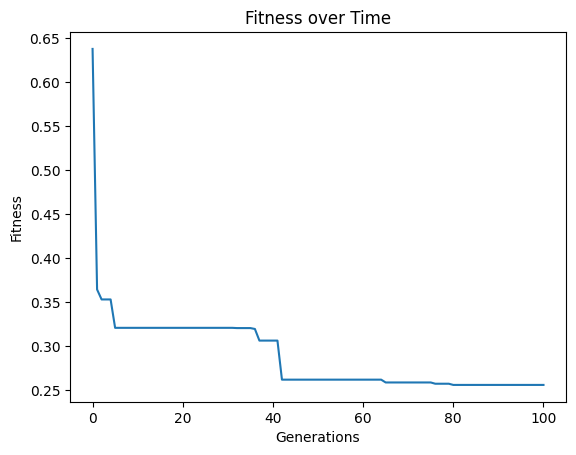

In [128]:
#Generate models
models=sgp.evolve(inputData,response,tracking=True, crossoverRate=11, mutationRate=79, spawnRate=5, elitismRate=5)

Below, we can see that increasing the spawn rate significantly made search less efficient. 

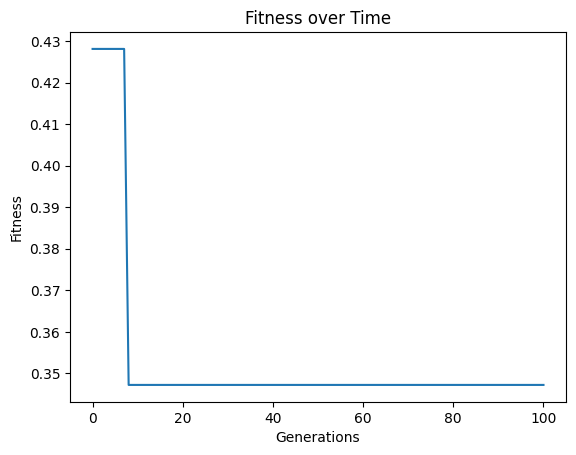

In [131]:
#Generate models
models=sgp.evolve(inputData,response,tracking=True,crossoverRate=0,mutationRate=0,spawnRate=90,elitismRate=10)

### extinction

We can introduce occasional extinction events by setting _extinction_ to be true. When an extinction occurs, all non-elite models will be removed and replaced with new random models. The frequency of extinction events will occur based on the set _extinctionRate_.

In [124]:
#Define a function to generate data
def demoFunc(x,y):
    return np.sin(x) * y
#Generate data
inputData=np.array([np.random.randint(1,10,10),np.random.randint(1,10,10)])
response=demoFunc(inputData[0],inputData[1])

By default, no extinction events occur. 

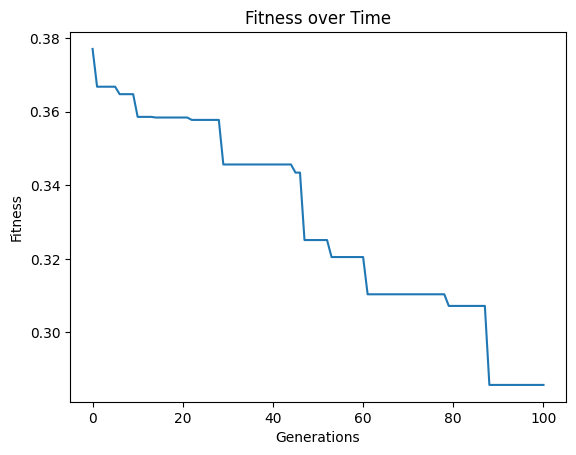

In [125]:
#Generate models
models=sgp.evolve(inputData,response,tracking=True, extinction=False)

We can set `extinction=True` and `extinctionRate=10` to make it so an extinction event occurs every 10th generation. 

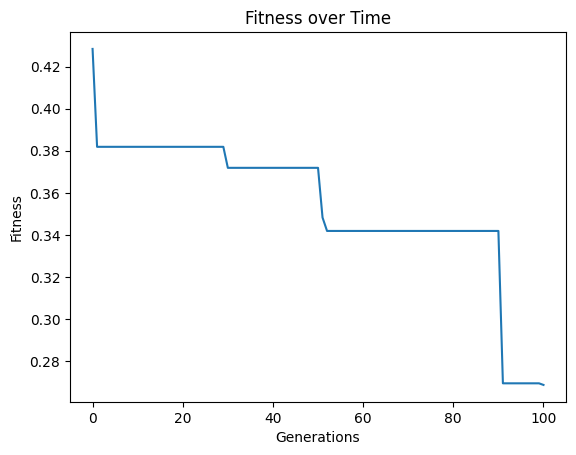

In [126]:
#Generate models
models=sgp.evolve(inputData,response,tracking=True, extinction=True, extinctionRate=10)

We can see what happens if we set extinction rate to 1, meaning every generation we have an extinction event. 

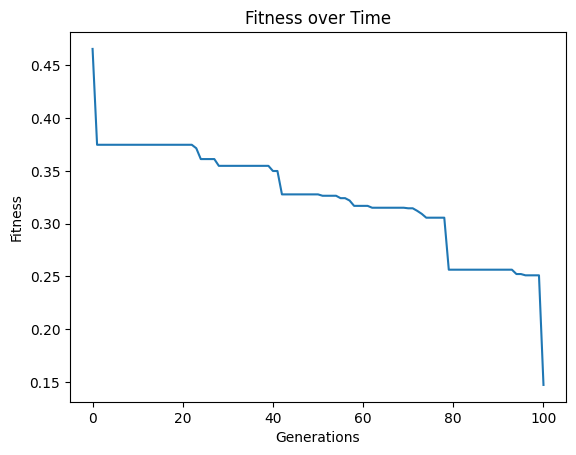

In [141]:
#Generate models
models=sgp.evolve(inputData,response,tracking=True, extinction=True, extinctionRate=1)

### extinctionRate

When _extinction_ is set to true, we can control the rate at which extinction events occur by setting the _extinctionRate_. When an extinction occurs, all non-elite models will be removed and replaced with new random models.

In [142]:
#Define a function to generate data
def demoFunc(x,y):
    return np.sin(x)/np.cos(y) * y**2
#Generate data
inputData=np.array([np.random.randint(1,10,10),np.random.randint(1,10,10)])
response=demoFunc(inputData[0],inputData[1])

We can set `extinction=True` and `extinctionRate=10` to make it so an extinction event occurs every 10th generation. 

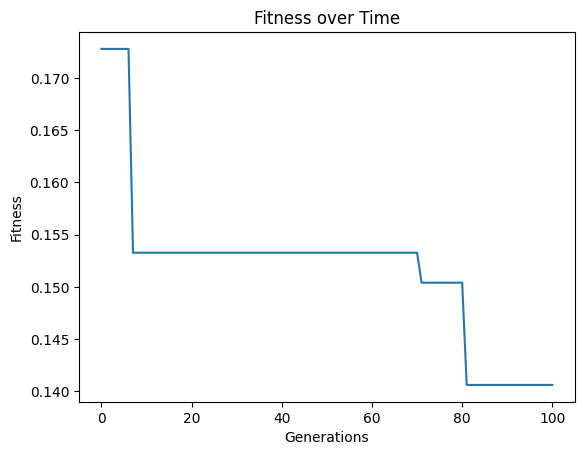

In [143]:
#Generate models
models=sgp.evolve(inputData,response,tracking=True, extinction=True, extinctionRate=10)

We can set `extinction=True` and `extinctionRate=5` to make it so an extinction event occurs every 5th generation. 

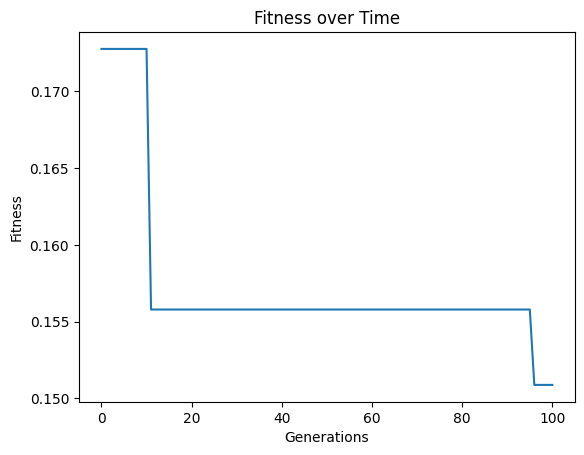

In [144]:
#Generate models
models=sgp.evolve(inputData,response,tracking=True, extinction=True, extinctionRate=5)

### elitismRate

We can control the percentage of elite individuals that are preserved across generations by setting the _elitismRate_. 

In [145]:
#Define a function to generate data
def demoFunc(x,y):
    return np.sin(x)/np.cos(y) * y**2
#Generate data
inputData=np.array([np.random.randint(1,10,10),np.random.randint(1,10,10)])
response=demoFunc(inputData[0],inputData[1])

Here we set `elitismRate=10` so the top 10% of the population will be preserved across generations. 

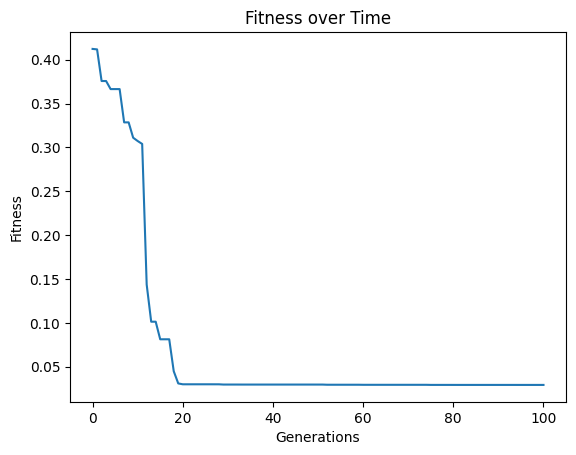

In [146]:
#Generate models
models=sgp.evolve(inputData,response,tracking=True, elitismRate=10)

Setting `elitismRate=0` will make it so no individuals are preserved across generations, so progress is not guaranteed. This can be observed by seeing that the evolution trace is no longer monotonic. 

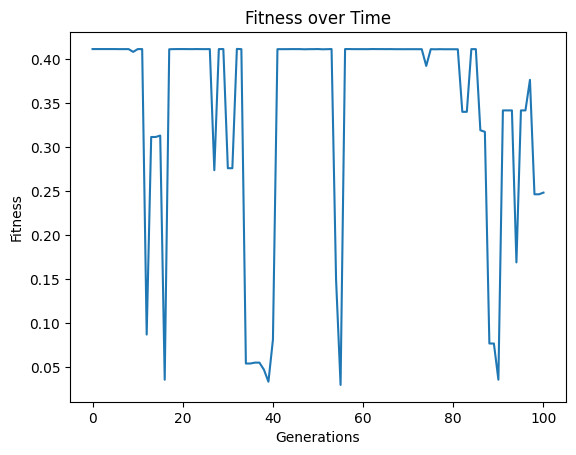

In [148]:
#Generate models
models=sgp.evolve(inputData,response,tracking=True, elitismRate=0)

### popSize

We can control the population size using the _popSize_ option. By default we target a population of 300 models. It may be the case that we want to increase the size to allow for more diverse models to exist, or we may want to make it easier to progress deeper into evolution by using smaller populations and making it less computationally expensive to evaluate each generation. 

In [149]:
#Define a function to generate data
def demoFunc(x,y):
    return np.sin(x)/np.cos(y) * y**2
#Generate data
inputData=np.array([np.random.randint(1,10,10),np.random.randint(1,10,10)])
response=demoFunc(inputData[0],inputData[1])

Below we set a very small population size of 10 models. We can see that it makes it through the set number of generations very quickly, but due to a lack of diversity, we don't get to very good models. 

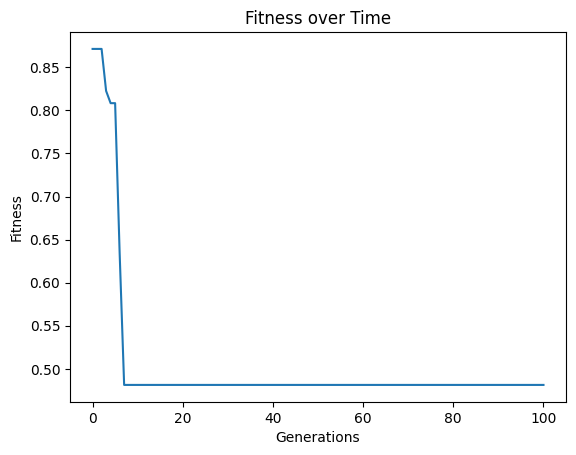

In [150]:
#Generate models
models=sgp.evolve(inputData,response,tracking=True, popSize=10)

Looking at the population, we can see there are very few models. 

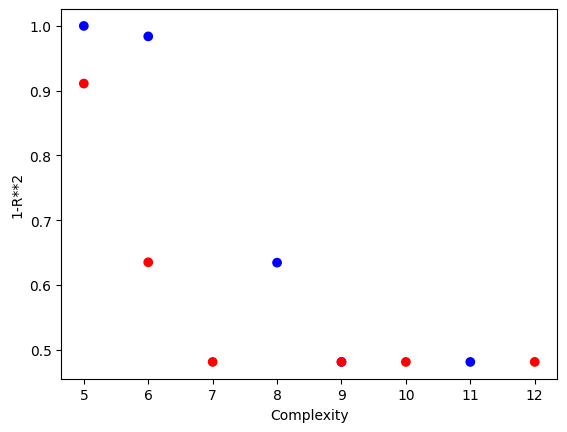

In [152]:
sgp.plotModels(models)

Using a population size of 1000 makes the evolution much slower, but we can see we arrived at much better models since the population contained more potentially useful genetic material to use. 

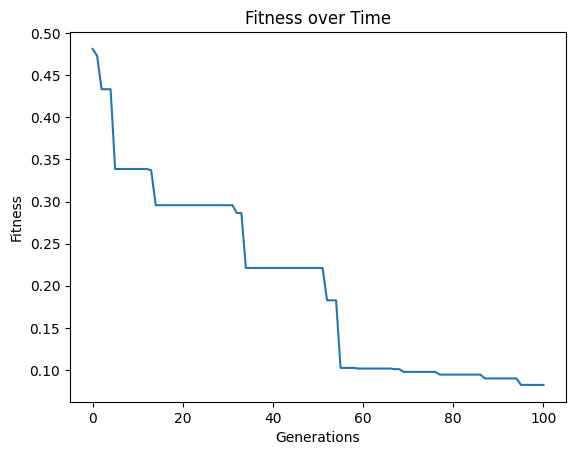

In [153]:
#Generate models
models=sgp.evolve(inputData,response,tracking=True, popSize=1000)

Looking at the population, we can see that there are many more models

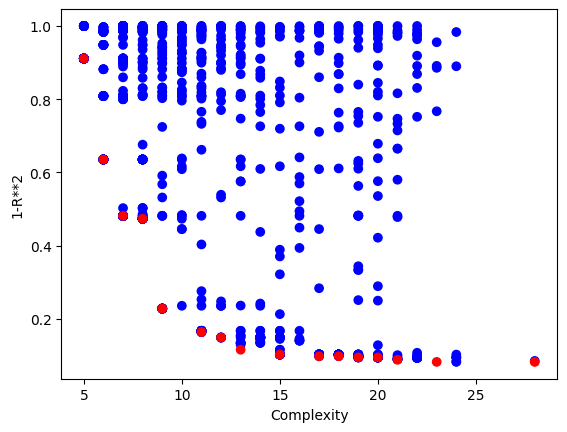

In [154]:
sgp.plotModels(models)

### maxComplexity

We can control the max complexity allowed in the search space by setting the _maxComplexity_ option. Complexity is determined by counting the total combined lengths of the operator and data stacks. 

In [155]:
#Define a function to generate data
def demoFunc(x,y):
    return np.sin(x)/np.cos(y) * y**2
#Generate data
inputData=np.array([np.random.randint(1,10,10),np.random.randint(1,10,10)])
response=demoFunc(inputData[0],inputData[1])

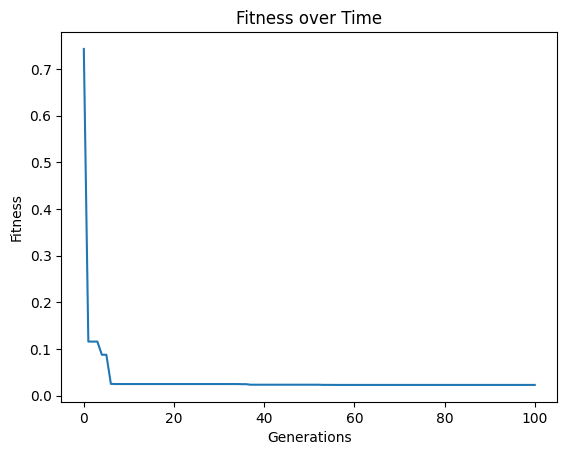

In [160]:
#Generate models
models=sgp.evolve(inputData,response,tracking=True, maxComplexity=10)

After search, some post processing steps may occur that could increase the model size slightly, so we can see some models a bit over the max complexity of 10. 

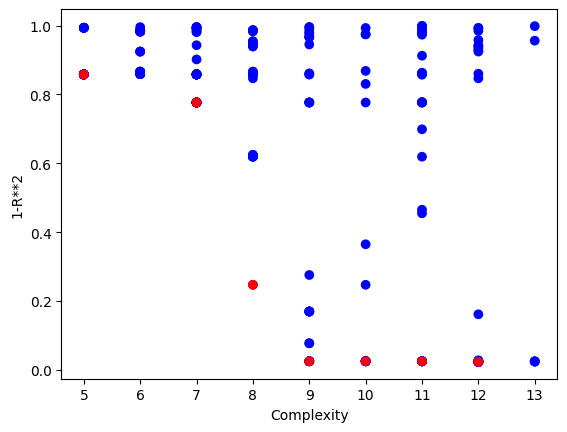

In [161]:
sgp.plotModels(models)

We can crank the complexity limit up to 1000 to see what happens. 

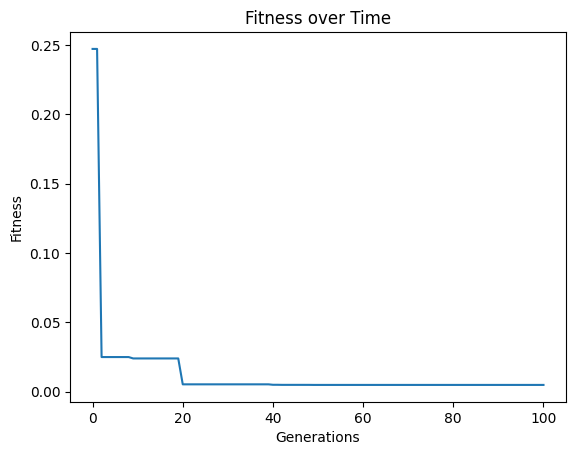

In [175]:
#Generate models
models=sgp.evolve(inputData,response,tracking=True, maxComplexity=1000)

Setting a max complexity does not mean we will get models up to that complexity. The search will prioritize simpler accurate models, so unless it is necessary, you won't see many models near a very high complexity limit. As we can see below, the models are hardly more complex than when we set the max complexity to 10. 

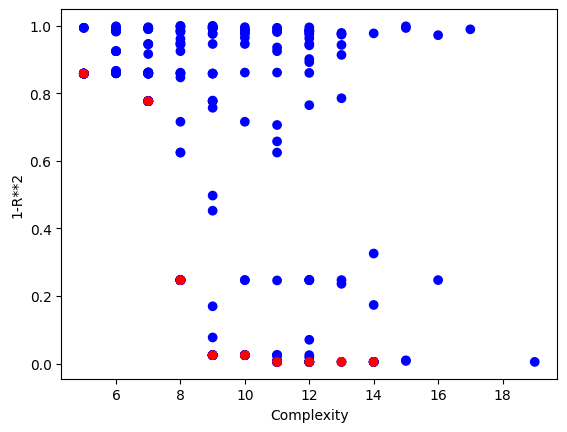

In [176]:
sgp.plotModels(models)

### align

The _align_ option is a binary setting which determines if models will undergo linear scaling at the end of evolution. Since the default accuracy metric is $R^2$, there is no guarantee that the model will have the best scaling and translation coefficient, so this scaling step is necessary to align the model with the training data. By default this option is set to True, but if a different accuracy metric is being used, such as RMSE, it may not be necessary to use the alignment. 

In [177]:
#Define a function to generate data
def demoFunc(x,y):
    return 5*x*y+2
#Generate data
inputData=np.array([np.random.randint(1,10,10),np.random.randint(1,10,10)])
response=demoFunc(inputData[0],inputData[1])

Lets first show what happens when we set `align=False`. We can see that we get to a model with essentially 0 error. 

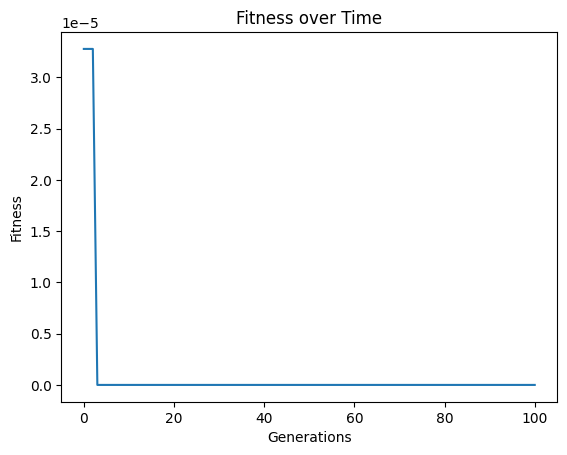

In [180]:
#Generate models
models=sgp.evolve(inputData,response,tracking=True, align=False)

When we look at the model though, we can see that it is clearly not the same as the function used to generate the data. It has a similar form, but the constants are wrong. 

In [181]:
sgp.printGPModel(models[0])

3.14159265358979*x0*x1

Now when we set `align=True` we again get to a model with essentially 0 error. 

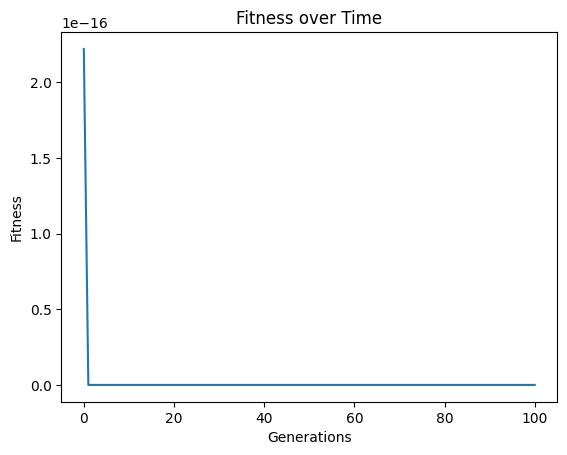

In [184]:
#Generate models
models=sgp.evolve(inputData,response,tracking=True, align=True)

When we look at the best model though, we can see that now it has the same form and constants as the formula used to generate the data. 

In [185]:
sgp.printGPModel(models[0])

5.0*x0*x1 + 2.0

### initialPop

We can seed the evolution by providing an initial population. Assuming we have previously generated models from other searches, this can allow us to transfer previously learned patterns into our current search to kick start the process. 

In [186]:
#Define a function to generate data
def demoFunc(x,y):
    return np.sin(x)/np.cos(y) * y**2
#Generate data
inputData=np.array([np.random.randint(1,10,10),np.random.randint(1,10,10)])
response=demoFunc(inputData[0],inputData[1])

We first need to run an initial evolution to get a population to feed into another search. 

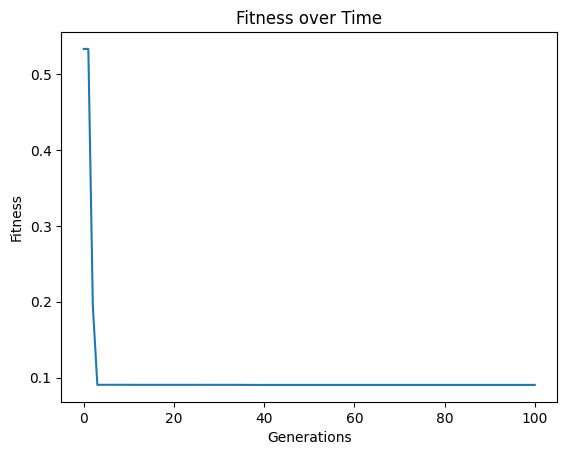

In [187]:
#Generate models
models=sgp.evolve(inputData,response,tracking=True)

We can see that the error trace begins where the previous search left off since the new search started with the previously evolved models. 

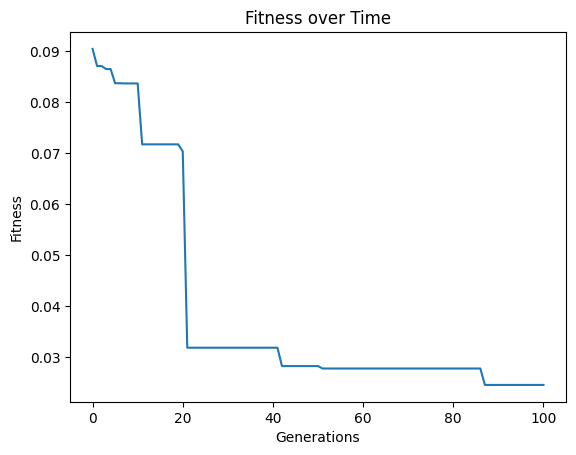

In [189]:
#Generate models
models=sgp.evolve(inputData,response,tracking=True,initialPop=models)

We can do this process as many times as we want to continue iteratively improving our models. 

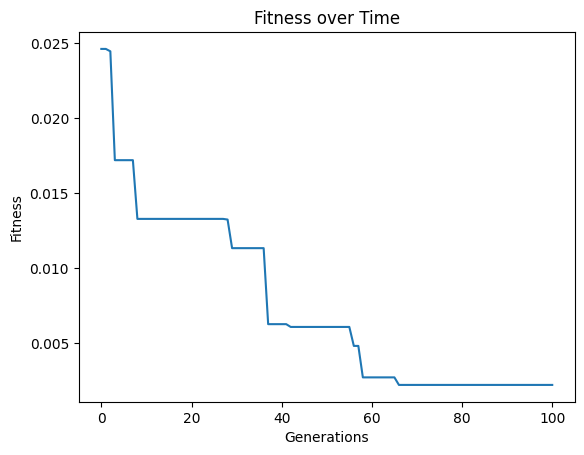

In [190]:
#Generate models
models=sgp.evolve(inputData,response,tracking=True,initialPop=models)

### timeLimit

Often, we are constrained by time when performing our analysis or modeling so we care about controlling the runtime of the search. We can set the max runtime by setting the _timeLimit_ option to the max number of seconds and setting the _capTime_ option to True. 

In [191]:
#Define a function to generate data
def demoFunc(x,y):
    return np.sin(x)/np.cos(y) * y**2
#Generate data
inputData=np.array([np.random.randint(1,10,10),np.random.randint(1,10,10)])
response=demoFunc(inputData[0],inputData[1])

By default, the search will run until a set number of generations has been completed. Depending on the problem, the actual runtime to complete a set number of generations can vary significantly and can be difficult to predict in advance. Therefore, a runtime limit is often more practical. The below example does not have a time limit and will run until it completes 10,000 generations. This process took about ~12 minutes to run. 

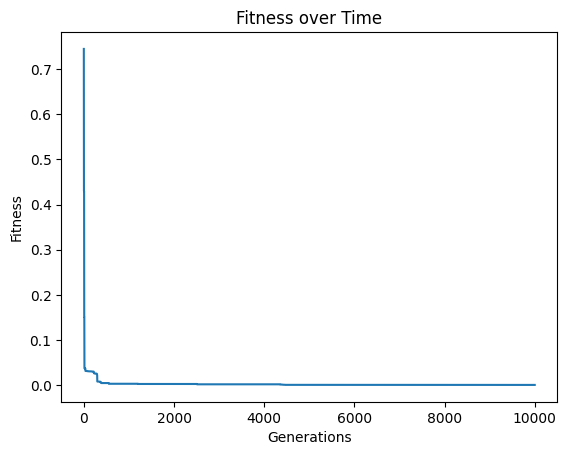

In [192]:
#Generate models
models=sgp.evolve(inputData,response,tracking=True,generations=10000)

Below we set `timeLimit=30` and `capTime=True` to stop the search when we reach 30 seconds of runtime. 

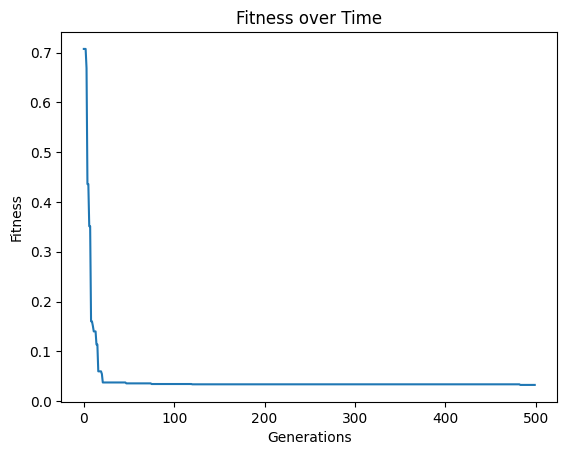

In [195]:
#Generate models
models=sgp.evolve(inputData,response,tracking=True,generations=10000, timeLimit=30, capTime=True)

If the number of generations are completed before the time limit the search will terminate. Below we can see that the 100 generation completes before the time limit of 60 seconds. 

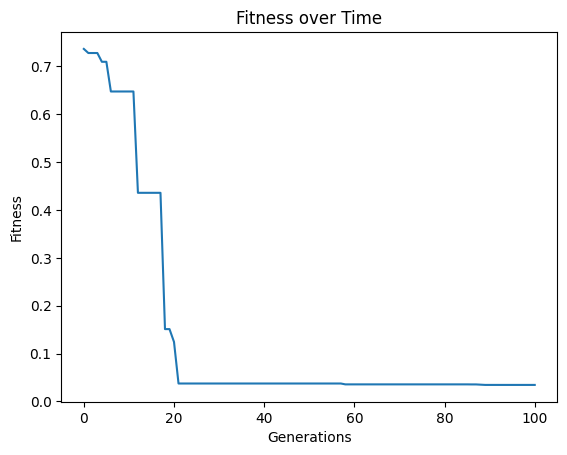

In [196]:
#Generate models
models=sgp.evolve(inputData,response,tracking=True,generations=100, timeLimit=60, capTime=True)

### tourneySize

We can control the tounament size used in selection by setting the _tourneySize_ option. Larger tournament sizes will make the search more greedy, while smaller sizes will make it less greedy. 

In [197]:
#Define a function to generate data
def demoFunc(x,y):
    return np.sin(x)/np.cos(y) * y**2
#Generate data
inputData=np.array([np.random.randint(1,10,10),np.random.randint(1,10,10)])
response=demoFunc(inputData[0],inputData[1])

The below shows an example where we set the tournament size to 5 models. 

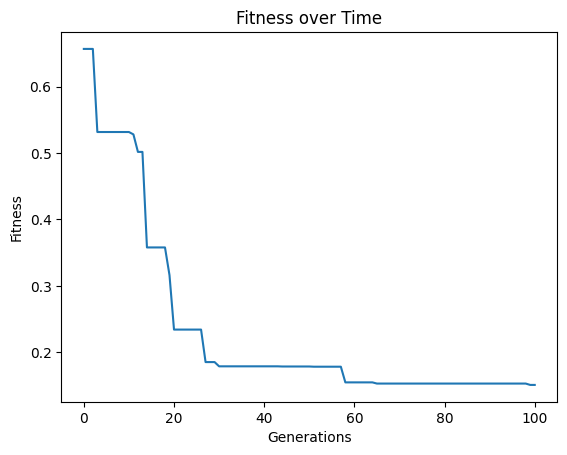

In [198]:
#Generate models
models=sgp.evolve(inputData,response,tracking=True,tourneySize=5)

Below we increase the tournament size to 30 models. 

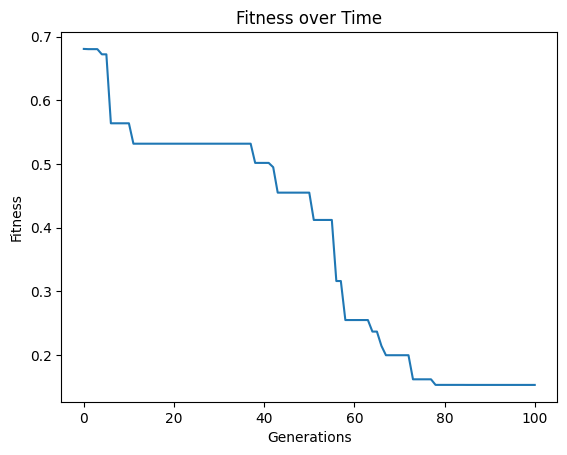

In [203]:
#Generate models
models=sgp.evolve(inputData,response,tracking=True,tourneySize=30)

### tracking

The _tracking_ option is a binary setting that allows us to visualize the evolution trace to see how the model search progressed. It has been set to True throughout most of the examples above to show the evolutionary search progress. If you don't want the trace plot cluttering up your notebook space or if you are calling the function headless, you may want to set it to False. 

In [204]:
#Define a function to generate data
def demoFunc(x,y):
    return np.sin(x)/np.cos(y) * y**2
#Generate data
inputData=np.array([np.random.randint(1,10,10),np.random.randint(1,10,10)])
response=demoFunc(inputData[0],inputData[1])

Below we can see that by setting `tracking=False`, nothing is displayed when running `evolve`. 

In [205]:
#Generate models
models=sgp.evolve(inputData,response,tracking=False)

Setting `tracking=True` below makes it so when we run `evolve` we see the evolution trace. 

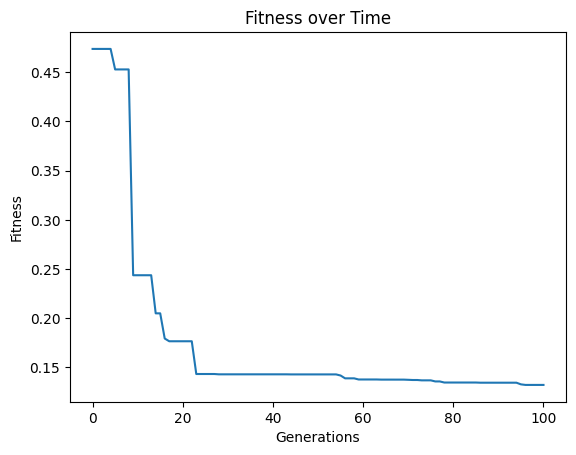

In [206]:
#Generate models
models=sgp.evolve(inputData,response,tracking=True)

### modelEvaluationMetrics

The choice of fitness objectives can have a significant impact on the success of search, so it is useful to be able to change these. These can be changed by providing them as a list to _modelEvaluationMetrics_. By default, `modelEvaluationMetrics=[fitness,stackGPModelComplexity]` is used, where `fitness` is $R^2$ and `stackGPModelComplexity` is combined stack length. A list of any length can be supplied. Each function in the list will be given as arguments the model, input data, and response vector in that order. 

In [2]:
#Define a function to generate data
def demoFunc(x,y):
    return np.sin(x)/np.cos(y) * y**2
#Generate data
inputData=np.array([np.random.randint(1,10,10),np.random.randint(1,10,10)])
response=demoFunc(inputData[0],inputData[1])

Below we define RMSE as a fitness function

In [3]:
#Define new fitness objective (RMSE)
def rmse(model, inputData, response):
    predictions = sgp.evaluateGPModel(model, inputData)
    return np.sqrt(np.mean((predictions - response) ** 2))

Below we use `rmse` and `stackGPModelComplexity` as our fitness objectives. 

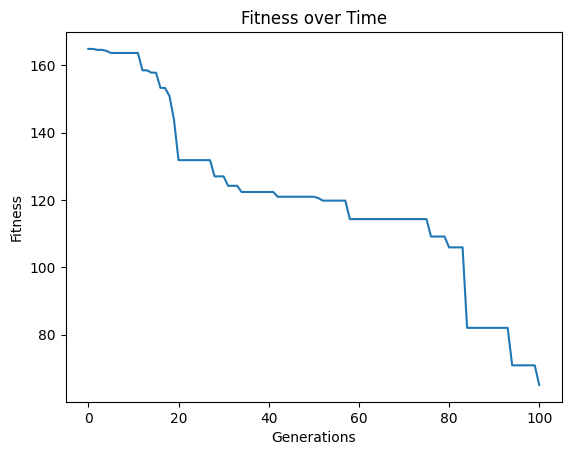

In [4]:
#Generate models
models=sgp.evolve(inputData,response,tracking=True,modelEvaluationMetrics=[rmse,sgp.stackGPModelComplexity])

We can see the form of the best model found. 

In [5]:
sgp.printGPModel(models[0])

-17.8294775841462*x1**2/(-0.448036177969462*x0**2 + 0.448036177969462*x1) - 26.8110354570213

Now we can compare the best model's predictions and the true response data. 

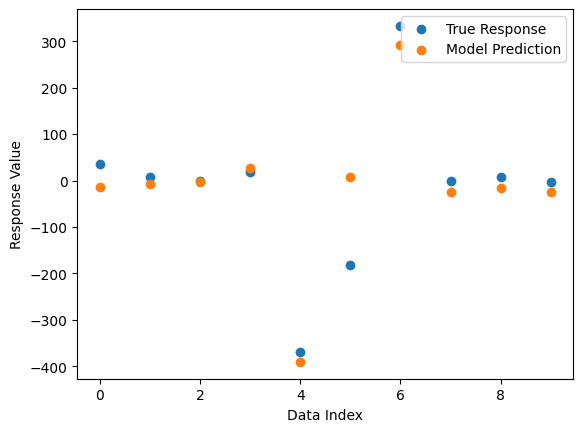

In [6]:
sgp.plotModelResponseComparison(models[0],inputData,response)

Now we change to use the default settings which uses `fitness` and `stackGPModelComplexity`. 

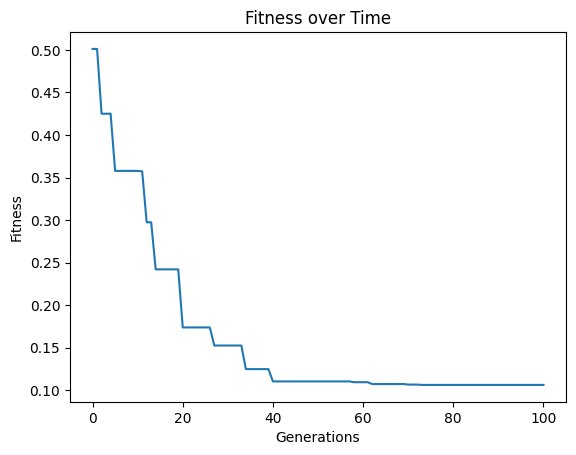

In [7]:
#Generate models
models=sgp.evolve(inputData,response,tracking=True,modelEvaluationMetrics=[sgp.fitness,sgp.stackGPModelComplexity])

Now we can see the form of the best model found during search. 

In [8]:
sgp.printGPModel(models[0])

-119.349053125999 + 335.724423637999/(-x1 + 1.39299130764398*sqrt(x1*(x0 + 5.23601810601064*sqrt(1/(x0*x1)))))

Now we compare the model's predictions to the true response values. 

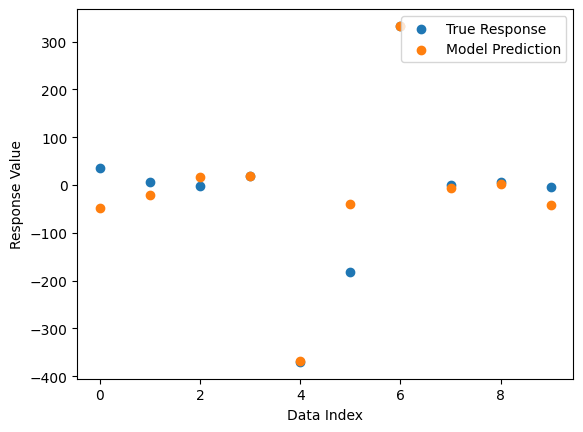

In [9]:
sgp.plotModelResponseComparison(models[0],inputData,response)

If we only want a single objective search, we can supply just one objective. Notice that the search takes longer since there is no constraint on model size, so models will become larger and more expensive to evaluate. 

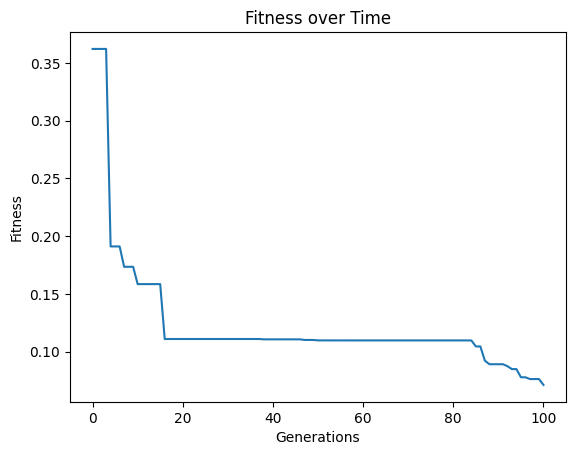

In [10]:
#Generate models
models=sgp.evolve(inputData,response,tracking=True,modelEvaluationMetrics=[sgp.fitness])

We can confirm this by looking at the size of models. We can see that many are fairly large. 

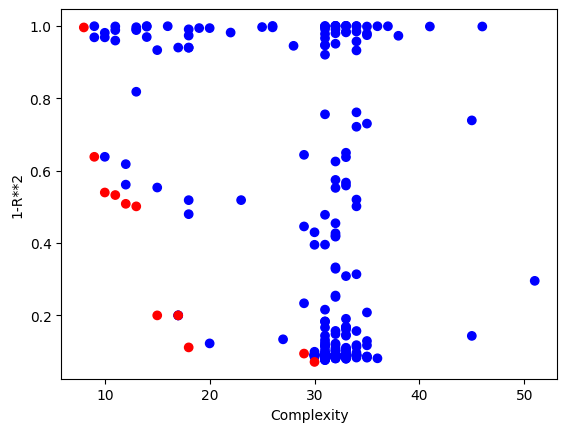

In [12]:
# Update the model quality using standard objectives so we can create the standard model quality plot
[sgp.setModelQuality(mods, inputData, response) for mods in models]
sgp.plotModels(models)

We may also be interested in optimizing on a 3D front. In this case, we can supply a list of 3 objectives. 

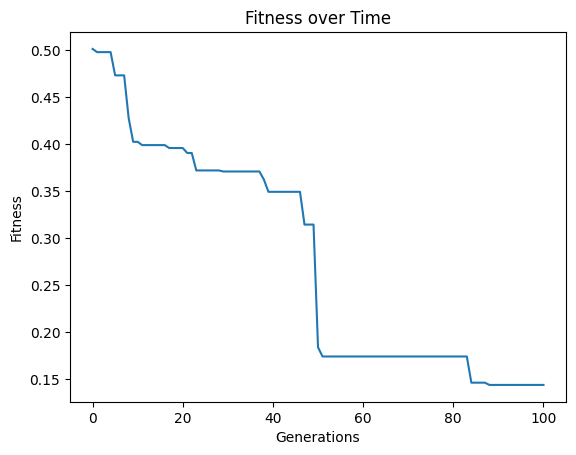

In [13]:
#Generate models
models=sgp.evolve(inputData,response,tracking=True,modelEvaluationMetrics=[sgp.fitness,sgp.stackGPModelComplexity, rmse])

The `plotModels` function will only plot with respect to the first two objectives. 

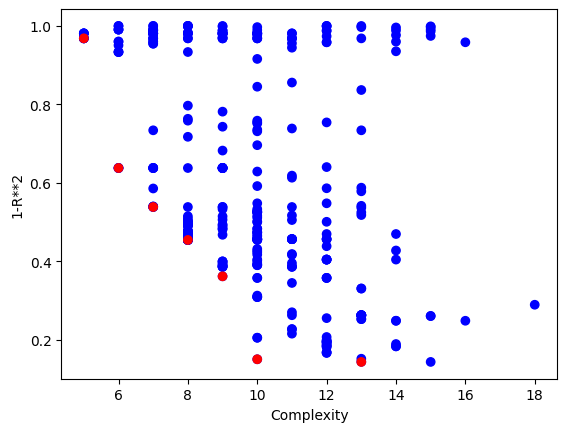

In [14]:
sgp.plotModels(models)

We can see the embedded quality of a model by grabbing the end of it. The order of objectives is the same as the order supplied. In this case `fitness`, `stackGPModelComplexity`, and `rmse`. 

In [16]:
models[0][-1]

[0.14417745021973816, 13, 63.54150112096759]

### dataSubsample

In scenarios where a data set is very large, it may cause training to be prohibitively slow. You could subsample the data set before passing it to the model training, but then the models are underinformed during training since they do not get the opportunity to learn about all the data. By setting `dataSubsample=True` you can supply the entire training set and then during evolution the set will be randomly sampled in each generation. The constant shuffling of data allows the models to learn from the whole data set while keeping training efficient since only a small set is used in each generation. 

In [16]:
#Define a function to generate data
def demoFunc(x,y):
    return np.sin(x)/np.cos(y) * y**2
#Generate data
inputData=np.array([np.random.randint(1,10,1000000),np.random.randint(1,10,1000000)])
response=demoFunc(inputData[0],inputData[1])

Running the code below, we can see it takes quite a while to train when using 1,000,000 training points. 

 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  5 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  5 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number 

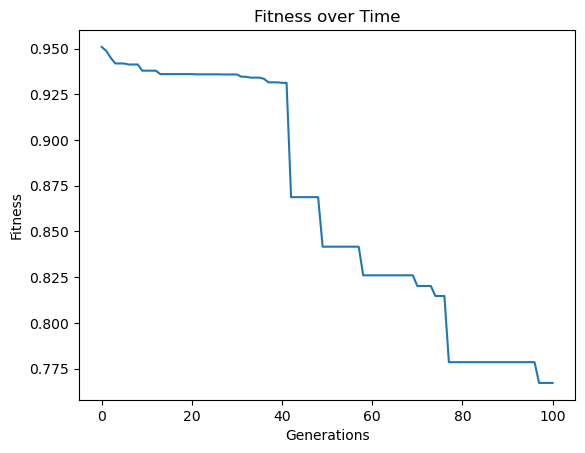

In [17]:
models=sgp.evolve(inputData,response,tracking=True)

When we enable data subsampling, we can see the training completes much faster. We can also notice that the training fitness no longer monotonically decreases since the training points used to determine fitness are constantly being resampled. 

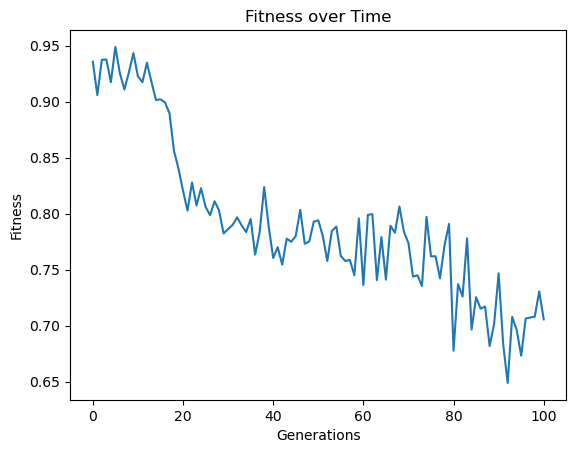

In [18]:
samplingModels=sgp.evolve(inputData,response,tracking=True,dataSubsample=True)

In a scenario where you are constrained by time, the subsampling can make a huge difference. For example,  below we constrain the search to 10 seconds and do not subsample. We can see that we make it through very few generations and the model quality does not improve very much. 

 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  5 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value


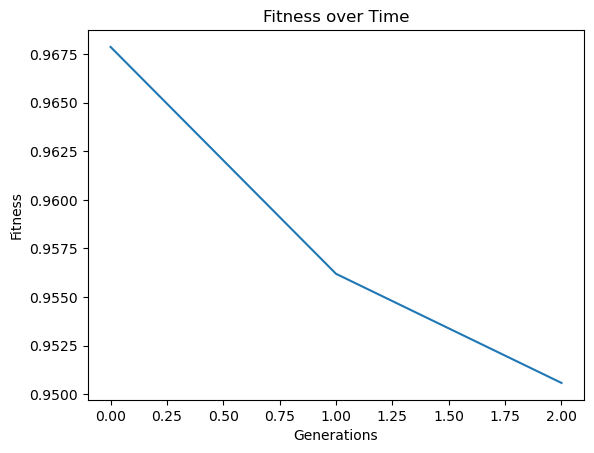

In [21]:
timeConstrainedModels=sgp.evolve(inputData,response,tracking=True,dataSubsample=False,capTime=True,timeLimit=10)

Below is the plot showing the quality of the models in the population. 

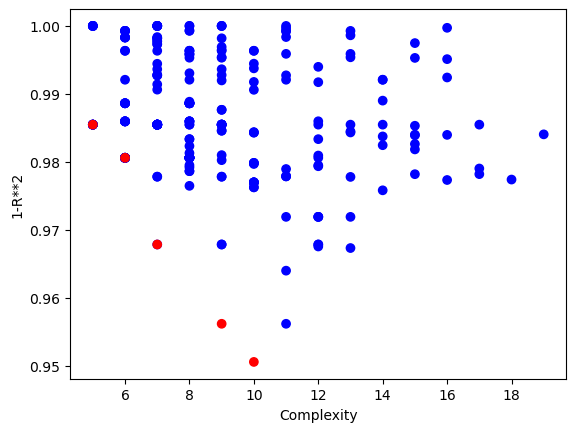

In [22]:
sgp.plotModels(timeConstrainedModels)

Now if we have the same time constraint but instead allow subsampling, we can make it through many more generations in that time. This also allows us to potentially find better models since the search is deeper. 

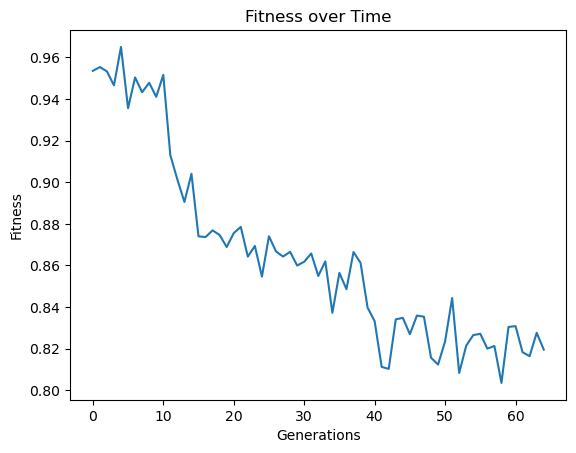

In [23]:
timeConstrainedSampledModels=sgp.evolve(inputData,response,tracking=True,dataSubsample=True,capTime=True,timeLimit=10)

Below is a plot showing the quality of models in the population. 

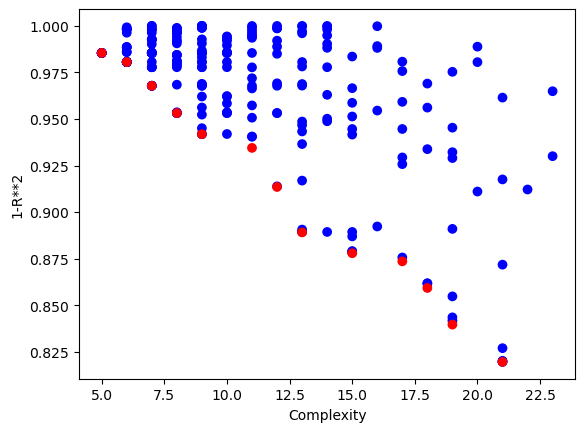

In [24]:
sgp.plotModels(timeConstrainedSampledModels)

### samplingMethod

In scenarios where a data set is very large, it may cause training to be prohibitively slow. You could subsample the data set before passing it to the model training, but then the models are underinformed during training since they do not get the opportunity to learn about all the data. By setting `dataSubsample=True` you can supply the entire training set and then during evolution the set will be randomly sampled in each generation. The constant shuffling of data allows the models to learn from the whole data set while keeping training efficient since only a small set is used in each generation. By default, when data sampling is active, the `randomSubsample` strategy is used. This strategy selects a new random sample every generation and the sample size remains the same across all generations. 

**Note**: Regardless of the subsampling strategy, before models are returned, all models are evaluated on the full training set so that the returned fitness values are representative of the model quality on the entire training set. 

In [2]:
#Define a function to generate data
def demoFunc(x,y):
    return np.sin(x)/np.cos(y) * y**2
#Generate data
inputData=np.array([np.random.randint(1,10,1000000),np.random.randint(1,10,1000000)])
response=demoFunc(inputData[0],inputData[1])

Here we use the `randomSubsample` strategy that randomly chooses a subset of the full training set each generation. 

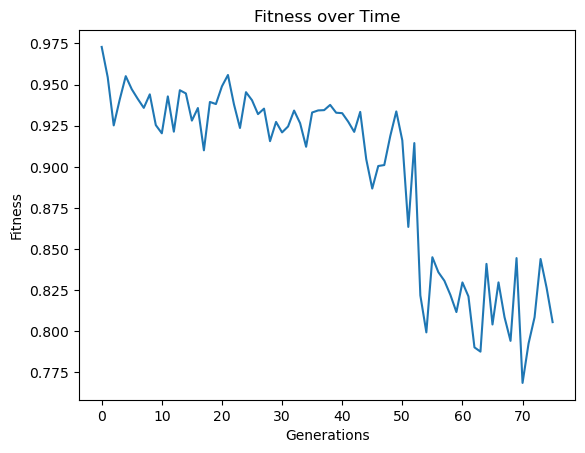

In [3]:
samplingModels=sgp.evolve(inputData,response,tracking=True,dataSubsample=True,samplingMethod=sgp.randomSubsample,capTime=True,timeLimit=10)

Here we use `generationProportionalSample` to start with a very small sample size and increase as we progress through generations. Note that the big jump in fitness is a result of starting with just 3 training points which is very easy to overfit, thus a near perfect fitness on the 3 point training set. 

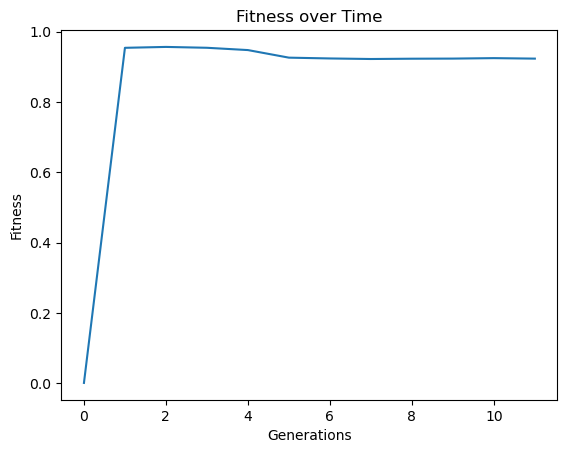

In [5]:
samplingModels=sgp.evolve(inputData,response,tracking=True,dataSubsample=True,samplingMethod=sgp.generationProportionalSample,capTime=True,timeLimit=10)

It is also possible to use user defined sampling methods. For example, here we implement a inverse generation proportional sampling. While it likely wouldn't be useful to do this, we can use this to illustrate how this can be done. 

In [6]:
def inverseGenerationProportionalSample(fullInput,fullResponse,generation,generations):
    prop=(generations-generation)/generations
    sampleSize=int(prop*len(fullResponse))
    if sampleSize<3:
        sampleSize=3
    indices=np.random.choice(len(fullResponse),size=sampleSize,replace=False)
    return fullInput[:,indices],fullResponse[indices]

We will make the training set a bit smaller to better showcase the impact here. 

In [9]:
inputData=np.array([np.random.randint(1,10,10000),np.random.randint(1,10,10000)])
response=demoFunc(inputData[0],inputData[1])

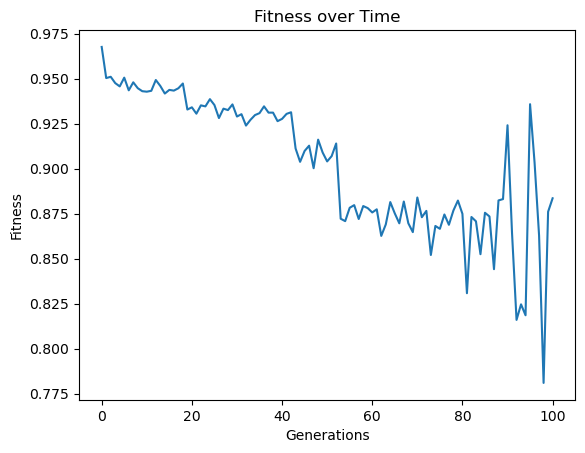

In [11]:
inverseSamplingModels=sgp.evolve(inputData,response,tracking=True,dataSubsample=True,samplingMethod=inverseGenerationProportionalSample,capTime=True)